## Imports

In [180]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

# basics
import pandas as pd
import json
import joblib

# feature_importance
import shap

# models
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split
)

# utils
import os
from ppm.nodes.metrics_calculator import (
    metrics_calculate,
    show_results
)
from ppm.nodes.cross_validation import (
    cross_validation
)
from ppm.nodes.process_outputs import (
    ranking_output
)
from ppm.nodes.feature_explainer import (
    tree_explainer,
    shap_explainer
)
from ppm.nodes.plots import (
    plot_feature_importance,
    plot_predictions,
    plot_true_vs_pred,
    plot_true_vs_pred_multiple
)
from ppm.nodes.outliers_detection import (
    detect_outliers
)

## Parameters

In [96]:
path_root = os.path.join("..","oos")
path_root_data = os.path.join("..", "data")
path_primary = os.path.join(
    path_root, "03_primary"
)
path_primary_data = os.path.join(
    path_root_data, "03_primary"
)
path_model = os.path.join(
    path_root_data, "04_model"
)
path_encoders = os.path.join(
    path_model, "encoders"
)
path_model_final = os.path.join(
    path_model, "model"
)

file_path_metrics_features_test = os.path.join(
    path_primary_data, "features_test_metrics.json"
)
file_path_metrics_features_selected = os.path.join(
    path_primary_data, "features_selected.json"
)
file_path_best_params = os.path.join(
    path_model, "best_params.json"
)
file_path_encoder_order = os.path.join(
    path_encoders, "encoders_orders.csv"
)
file_path_data_input = os.path.join(
    path_primary, "data_input.csv" 
)

In [190]:
n_samples_oos = -1
price_cutoff = 2*10**(6)

## Read content

In [191]:
data_input = pd.read_csv(
    file_path_data_input, # file_path_input_data, file_path_not_outliers
    index_col = 0
)

In [192]:
encoders_order = pd.read_csv(
    file_path_encoder_order
)

In [193]:
# read encoders
encoders = {}
for encoder_content in encoders_order.values:
    encoder_name, encoder_url = encoder_content
    encoders[encoder_name.split(".")[0]] = joblib.load(
        encoder_url
    )

In [194]:
# read model pycaret
model = {}
for model_name in os.listdir(path_model_final):
    model[model_name.split(".")[0]] = joblib.load(
        os.path.join(
            path_model_final,
            model_name
        )
    )

In [195]:
if os.path.exists(file_path_metrics_features_selected):
    with open(file_path_metrics_features_selected, 'r') as json_file:
        features_selected = json.load(json_file)
    features_selected = features_selected["selected_features"]

In [196]:
if os.path.exists(file_path_best_params):
    with open(file_path_best_params, 'r') as json_file:
        best_params = json.load(json_file)
    best_params = best_params["params"]
else:
    best_params = {
        "random_state": 42
    }

In [197]:
estimator = model["actual_estimator"]

In [198]:
target = [
    "price"
]
cd_setor_drop = [
    "cd_setor",
]
id_drop = [
    "ID"
]

In [199]:
data_input = data_input[data_input[target].values < price_cutoff].reset_index(drop = True)
data_input = data_input.head(n_samples_oos).copy()

In [200]:
data_input = data_input[id_drop + cd_setor_drop + target + features_selected].copy()

In [201]:
X = data_input.drop(
    cd_setor_drop + target,
    axis = 1
).copy()
y = data_input[id_drop + target].copy()

## Encoders process

In [202]:
encoded_data = {
    "oos": X.copy()
}
for encoder_name, encoder_content in encoders.items():
    print("--- encoder: [{}]".format(encoder_name))
    for type_name, data_to_encoder in encoded_data.items():
        id_row = data_to_encoder[id_drop[0]].values
        data_to_encoder.drop(id_drop[0], axis = 1, inplace = True)
        encoded_data[type_name] = encoder_content.transform(data_to_encoder)
        encoded_data[type_name].insert(0, id_drop[0], id_row)

--- encoder: [numerical_imputer]
--- encoder: [categorical_imputer]
--- encoder: [clean_column_names]


In [203]:
X_encoded = encoded_data['oos'].drop(id_drop, axis = 1).copy()

## Metrics

In [204]:
y_oos_preds = estimator.predict(X_encoded)

In [205]:
args_oos = [
    y[target[0]].values,
    y_oos_preds
]

metrics_oos = metrics_calculate(args_oos)

metrics_oos = show_results(metrics_oos, "oos")
metrics_results = metrics_oos

-------- [ oos ] ----------
r2 : 0.5622
mape : 0.5488
rmse : 236542.0741
mse : 55952152835.5988
mae : 141257.4656
median_ae : 72640.566
correlation : 0.7845
size : 1410


In [206]:
data_values = {}
for name, args in zip(['oos'], [args_oos]):
    content = ranking_output(args)
    data_values[name] = content

In [207]:
data_values['oos'].filter(regex = r"y_*").corr()

,y_true,y_pred
y_true,1.000000,0.784489
y_pred,0.784489,1.000000


In [208]:
data_values['oos'].filter(regex = r"rank_*").corr()

,rank_true,rank_pred
rank_true,1.000000,0.859441
rank_pred,0.859441,1.000000


## Feature importances

In [209]:
feature_importances, features_selected = tree_explainer(
    model = [estimator],
    features_names = list(X_encoded.columns),
    n_features = 10
)

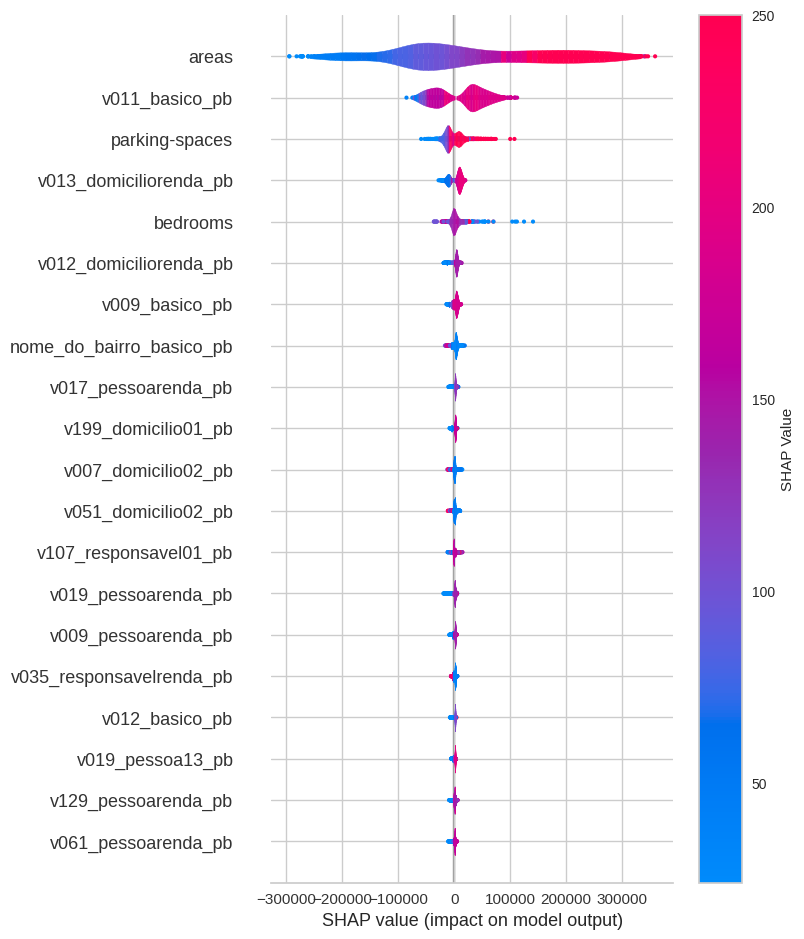

In [210]:
fig_shap, explainer = shap_explainer(
    [estimator],
    X_encoded
)

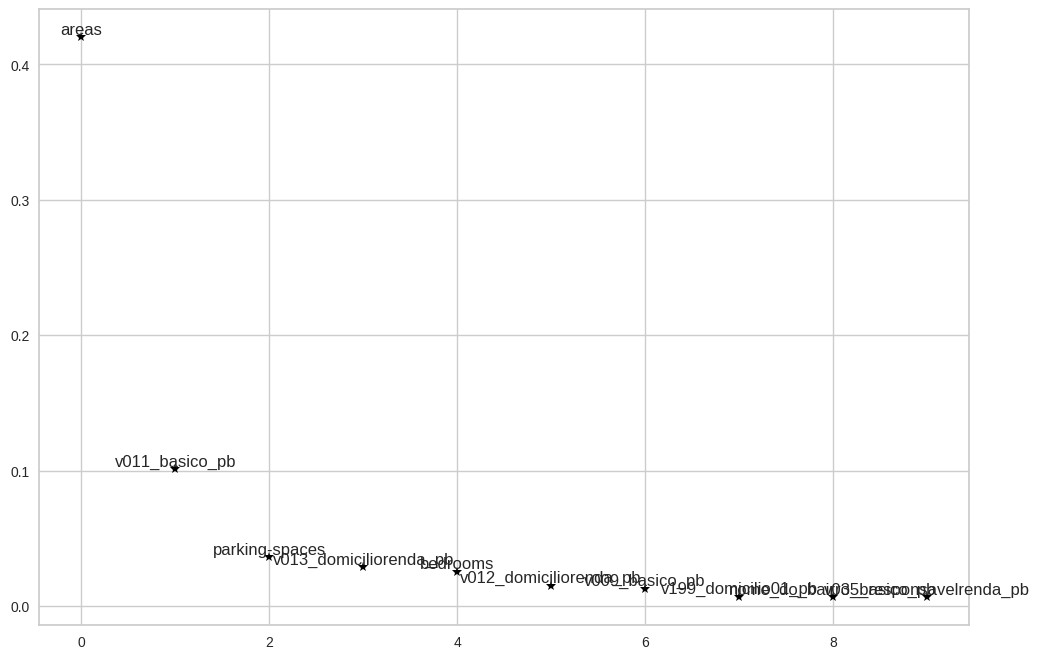

In [211]:
fig_tree_explainer = plot_feature_importance(
    feature_importances, 
    10
)

## Plots

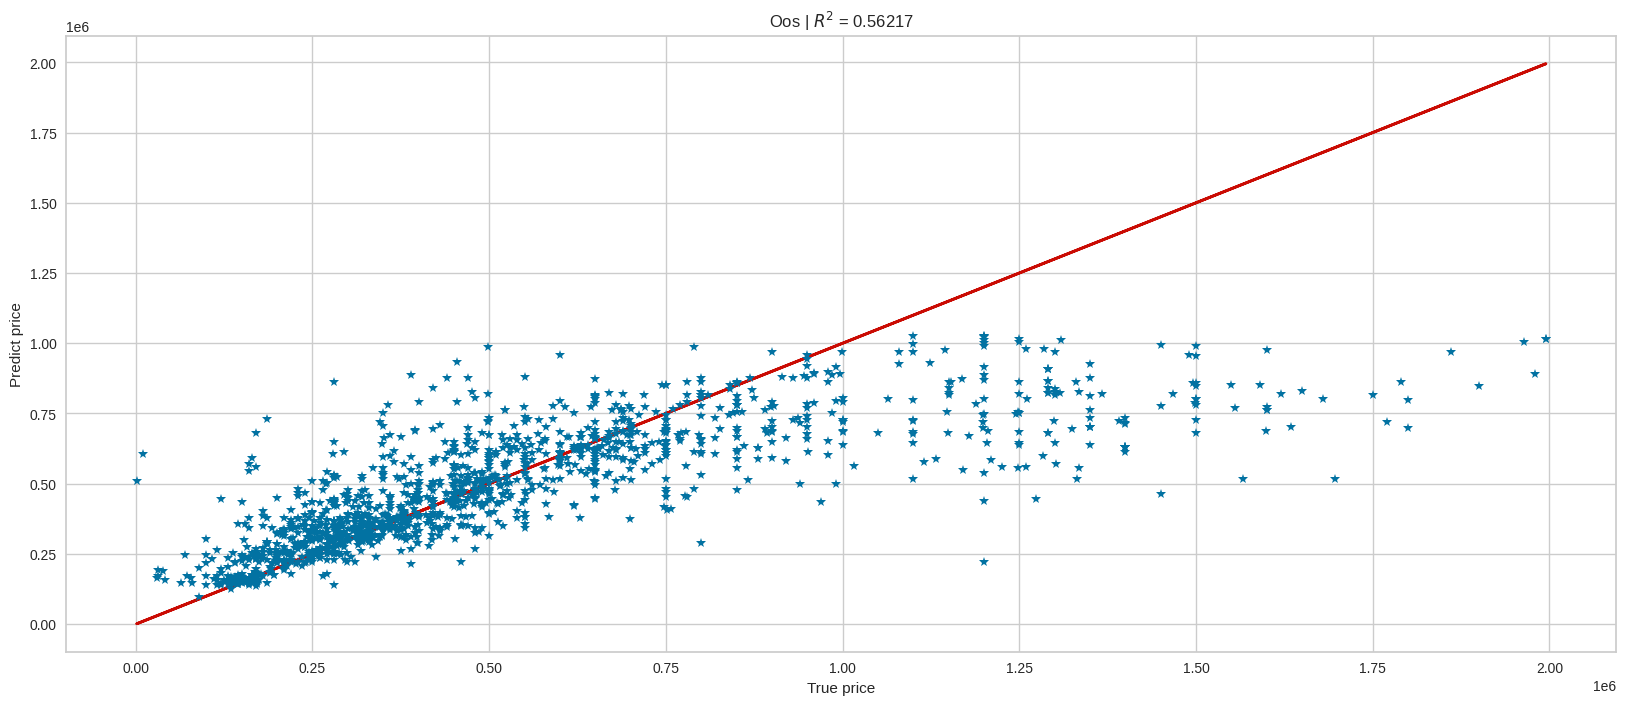

In [212]:
fig_oos_true_pred = plot_true_vs_pred_multiple(
    data_values,
    metrics_results,
    target,
    linewidth = 2
    #linestyle='dashed'
)

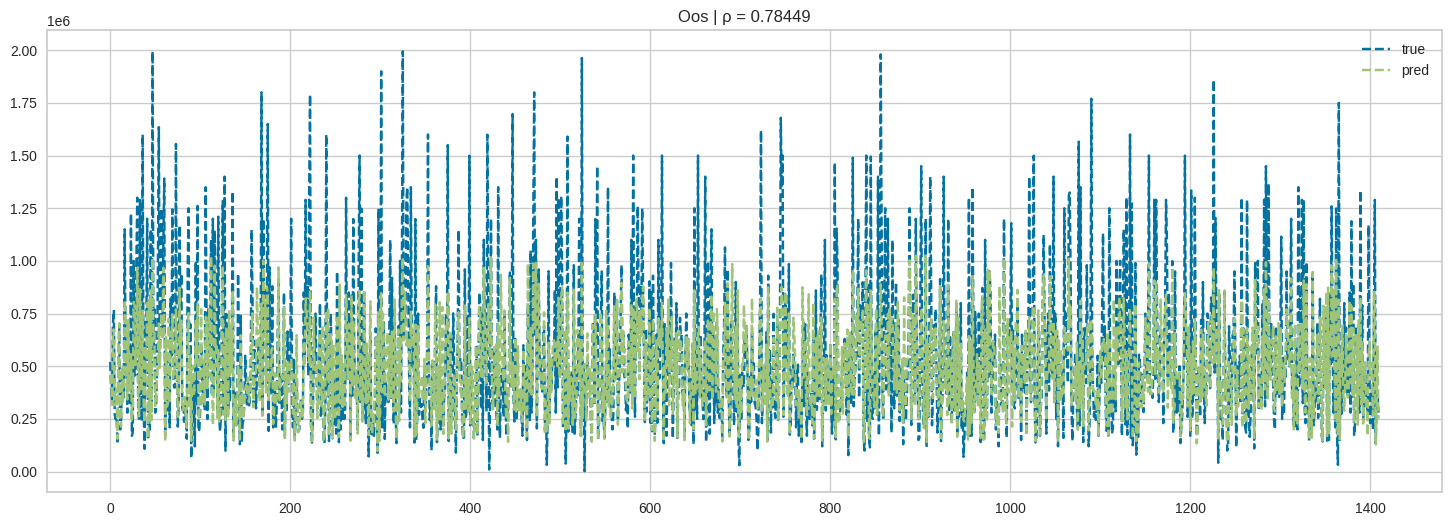

In [213]:
fig_true_vs_pred = plot_true_vs_pred(
    data_values,
    None,
    None,
    figsize = (18, 6),
    linestyle = 'dashed'
)